In [127]:
print("\n--- Bem vindo ao Projeto de Reconhecimento de Audio ---")
print("\nRealizando Imports de Libs necessarias...")

import librosa
import glob
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as sg
# from scipy.fftpack import dct
# from scipy.fftpack import fft
# from scipy.fftpack import ifft
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix



--- Bem vindo ao Projeto de Reconhecimento de Audio ---

Realizando Imports de Libs necessarias...


In [149]:
# calculo do Chroma Energy Normalized Statistics (CENS) do sinal
def calc_chroma(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.chroma_cens(y=av, sr=sr, n_chroma=24).T, axis=0)

# calculo do Mel Spectrogram do sinal
def calc_mel(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.melspectrogram(av, sr=sr).T, axis=0)

# calculo do MFCC medio para cada audio de entrada
def calc_mfcc(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.mfcc(y=av, sr=sr, n_mfcc=24).T, axis=0)

def lowPassFilter(signal):
    N  = 5   # Filter order
    Wn = 0.2 # Cutoff frequency
    B, A = sg.butter(N, Wn, output='ba')
    smooth_data = sg.filtfilt(B,A, signal)
    return smooth_data

In [3]:

# realiza a extracao de features do sinal
def feature_extraction(segmento, sr):
    features = []
    np.array(features)

    features = np.append(features, calc_mfcc(segmento, sr))
    features = np.append(features, calc_mel(segmento, sr))
    features = np.append(features, calc_chroma(segmento, sr))
    """
    features = np.append(features, calc_dct(segmento))
    features = np.append(features, calc_fft(segmento))
    """
    return features

# divisao dos audios de entrada para separacao de cada letra
def extract_intervals(signal, cut):
    data_interval = []
    interval = int(len(signal) // cut)
    for i in range(0, cut) :
        data_interval.append(pd.Series(signal[i*interval : (i+1)*interval]))
    return data_interval

# quebra o nome do arquivo em letras para categorizacao dos audios
def get_labels(path_file):
    path_file = re.sub("[ (1)]", "", path_file)
    return list(path_file[-8:-4])

# faz a aquisicao do caminho de todos os arquivos na pasta path
def get_files(path):
    files = glob.glob(path + "*.wav")
    return files

def get_x_y(path, reduce=False):
    files = get_files(path)
    Xt = []
    yt = []
    segmentos = []
    seed = random.randint(1, 1000)
    random.seed(seed)
    random.shuffle(files)
    # print(f"Semente gerada: {seed}\n")
    i = 0
    for f in files:
        data, sr = librosa.load(f, mono=True)
        segmentos += extract_intervals(data, 4)
        yt += get_labels(f)
        # print(i)
        if i > 30 and reduce:
            break    
        i += 1
        

    for segmento in segmentos:
        Xt.append(feature_extraction(segmento, sr))
    
    return Xt,yt

# lista os elementos (caracteres) unicos de um array
def unique_values(l):
    unique_list = []
    for x in l: 
        if x not in unique_list: 
            unique_list.append(x)
    return unique_list

In [4]:
# gera e imprime a matriz de confusao geral do modelo
def print_conf_mtx(yt, y_pred, labels, classifier):
    print(labels)
    print()
    cm = confusion_matrix(yt, y_pred, labels)
    print(cm)
    """
    print("\nMatrizes de Confusao Individuais")
    print(multilabel_confusion_matrix(yt, y_pred))
    """
    
    print("\nPlotando Confusion Matrix geral usando o matplotlib...")
    print("Feche o arquivo de saída para continuar a execução")

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the ' + classifier + ' classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.locator_params(nbins=len(labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [5]:
train_path = 'TREINAMENTO/'
validation_path= 'VALIDACAO/'
test_path = ''

In [14]:
reduce = True
files = get_files(train_path)
Xt = []
yt = []
segmentos = []
seed = 4
random.seed(seed)
random.shuffle(files)
# print(f"Semente gerada: {seed}\n")
i = 0
for f in files:
    data, sr = librosa.load(f, mono=True)
    segmentos += extract_intervals(data, 4)
    yt += get_labels(f)
    # print(i)
    if i > 30 and reduce:
        break    
    i += 1

In [19]:
labels = unique_values(yt)

In [22]:
labels

['h', '6', 'b', '7', 'n', 'c', 'x', 'a', 'm', 'd']

In [23]:
df_seg = pd.DataFrame(segmentos)

In [29]:
df_seg = df_seg.dropna(axis='columns')

In [32]:
df_seg['class'] = yt

C:\Users\renan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [243]:
samples_ls = []
for l in labels:
    samples_ls.append(df_seg[df_seg['class'] == l].head(1))

samples_df = pd.concat(samples_ls)

In [244]:
samples_df.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,43383,43384,43385,43386,43387,43388,43389,43390,43391,class
0,-0.000045,1.827192e-04,2.419269e-04,-1.780833e-04,-2.462200e-05,1.917978e-04,2.705709e-04,-1.661168e-04,-1.766351e-05,3.936181e-04,...,4.773654e-05,2.866820e-05,1.743612e-04,-7.986718e-05,-1.821237e-05,-9.815672e-05,-2.663398e-04,-2.100232e-04,-1.473549e-04,h
1,-0.000874,-7.266447e-04,-9.263864e-04,-7.057527e-04,-3.317074e-04,-5.410070e-04,-5.132099e-04,-7.863322e-04,-6.621805e-04,-6.501649e-04,...,1.182096e-03,2.603746e-03,2.468487e-03,1.750205e-03,1.979308e-03,1.590323e-03,1.688874e-03,4.400776e-03,6.122485e-03,6
2,-0.000113,4.453108e-04,6.306997e-04,-5.190484e-04,-1.396990e-03,-1.834419e-03,-1.188889e-03,1.384068e-04,1.094496e-03,2.971428e-03,...,-1.719885e-05,-1.325286e-05,7.008216e-04,1.768053e-03,2.063305e-03,1.993849e-03,2.019014e-03,2.157064e-03,2.295074e-03,b
3,-0.002424,-2.967573e-03,-3.392265e-03,-3.675091e-03,-3.906638e-03,-3.795903e-03,-3.718840e-03,-3.745082e-03,-4.297547e-03,-4.303850e-03,...,2.627383e-04,-2.362903e-04,-6.212963e-04,-6.605053e-04,9.299869e-05,3.140785e-04,3.008932e-04,1.855255e-04,5.490753e-04,7
4,-0.000931,-1.476549e-03,-1.049067e-03,-1.275903e-03,-1.658302e-03,-1.664873e-03,-2.273435e-03,-2.163738e-03,-2.237994e-03,-2.196638e-03,...,-2.672749e-04,-9.312411e-04,-1.219160e-03,-1.195056e-03,-1.049775e-03,-6.861141e-04,-1.301280e-03,-1.307127e-03,-1.490006e-03,n
5,-0.000411,-1.297710e-03,-4.850754e-04,-3.877216e-04,-5.544943e-04,-7.837975e-04,-3.774457e-04,1.079940e-04,-7.709050e-04,-1.493227e-04,...,-3.487204e-03,-4.313696e-03,-4.178002e-03,-4.551702e-03,-3.974707e-03,-3.961993e-03,-3.336934e-03,-3.068635e-03,-3.206954e-03,c
6,0.000014,8.351087e-07,-8.201722e-07,7.933892e-07,-7.548801e-07,7.050202e-07,-6.444361e-07,5.739965e-07,-4.948019e-07,4.081700e-07,...,1.943500e-09,-2.059164e-09,2.000978e-09,-1.834044e-09,1.616062e-09,-1.394489e-09,1.208666e-09,-1.089422e-09,1.062906e-09,x
7,-0.000495,-3.042843e-04,-1.402559e-04,-1.019748e-05,-2.879779e-06,-1.595770e-04,-3.158867e-04,-2.400344e-04,-8.529158e-05,-4.676380e-06,...,-1.131216e-04,-1.410825e-04,-1.332641e-04,-1.028869e-04,-1.051006e-04,-1.963978e-04,-2.379244e-04,-2.616332e-04,-3.724939e-04,a
8,-0.000425,5.002937e-05,-2.028223e-04,-3.952060e-04,-5.555779e-04,-5.398922e-04,-3.551907e-04,-7.048526e-04,-7.973507e-04,-6.134242e-04,...,-6.381314e-04,-2.819169e-04,-3.080497e-04,-2.481881e-04,-1.470843e-04,-4.277031e-04,-5.151418e-04,-7.799501e-05,-1.707797e-04,m
9,0.000611,1.042690e-03,1.055109e-03,1.379595e-03,1.549197e-03,1.659095e-03,1.611037e-03,1.610999e-03,1.663873e-03,1.521652e-03,...,-4.733536e-04,-1.021628e-04,-6.263462e-05,-1.287279e-04,1.324155e-04,4.979687e-05,3.813484e-04,7.403121e-04,9.355571e-04,d


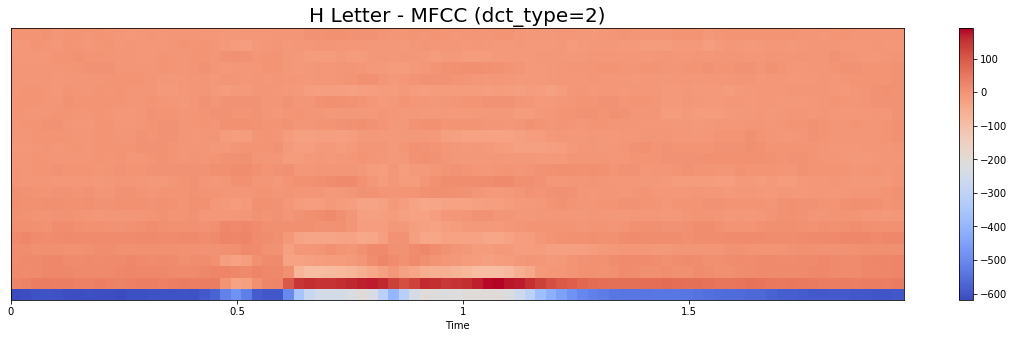

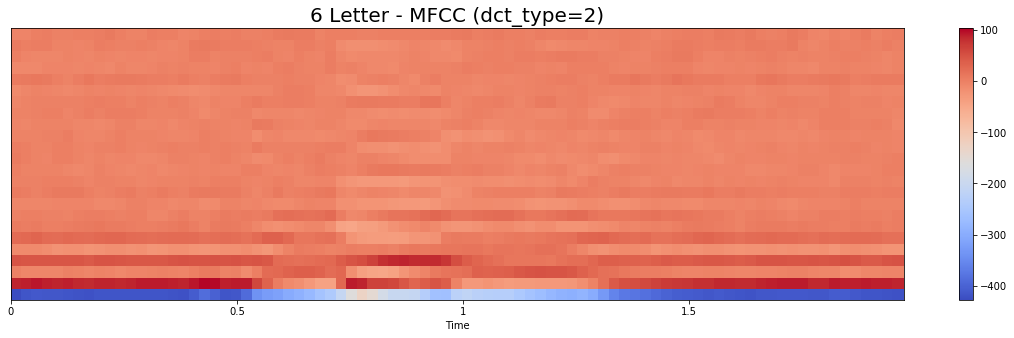

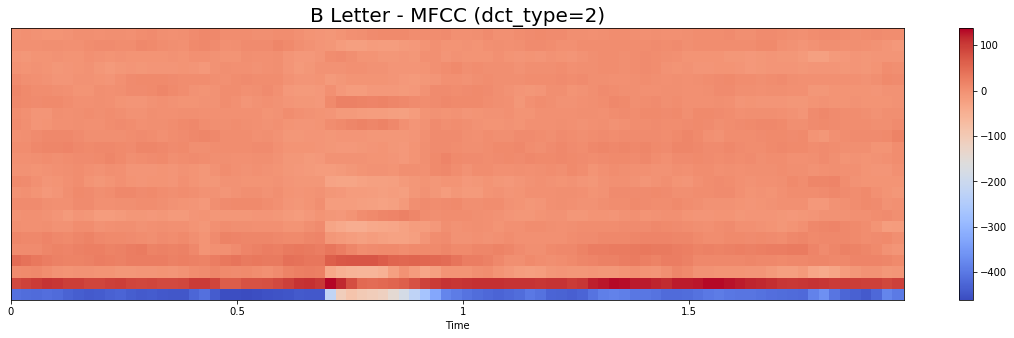

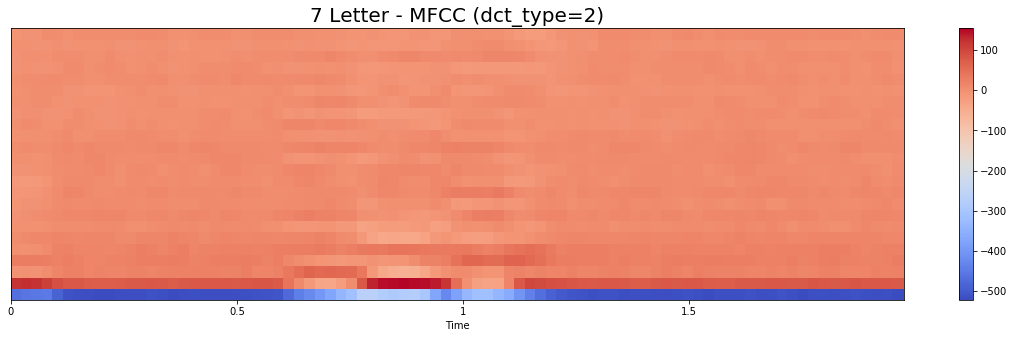

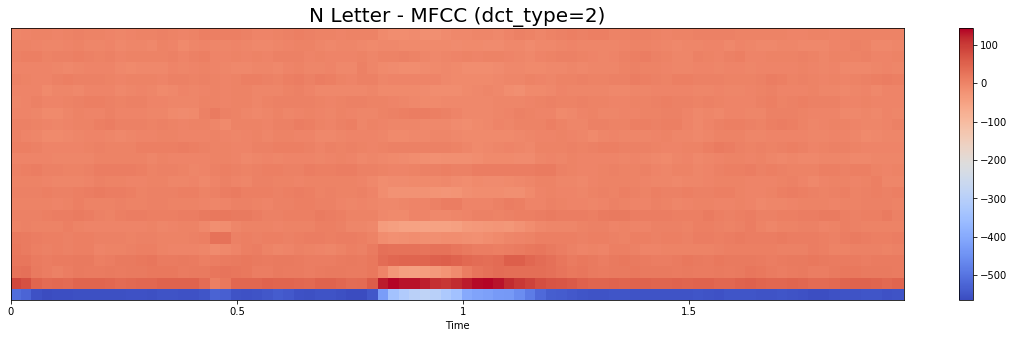

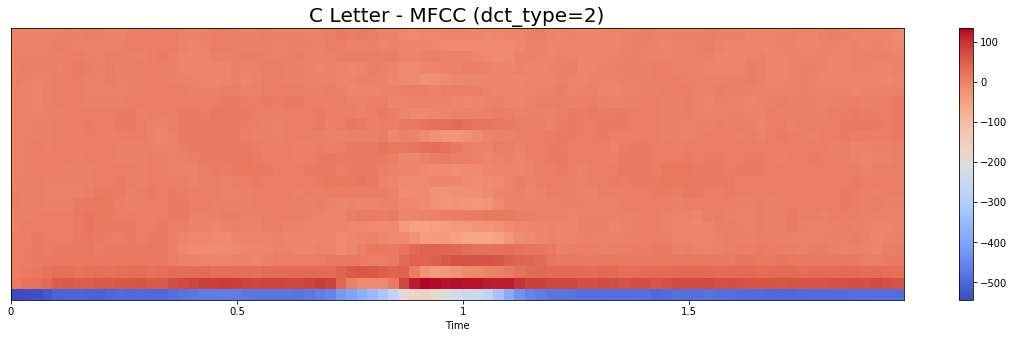

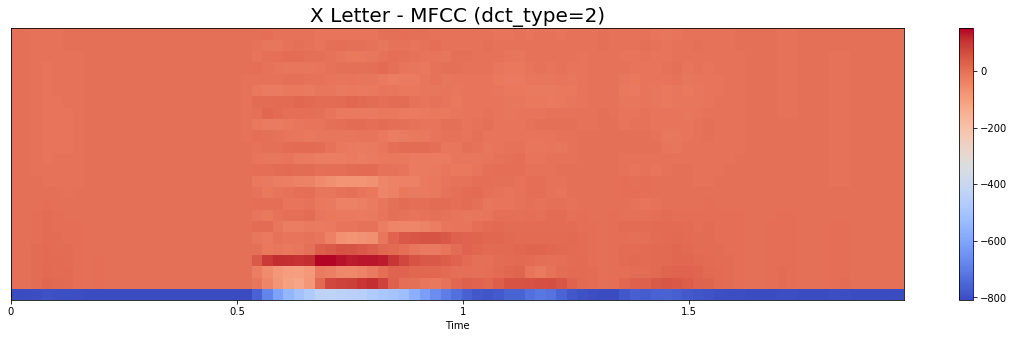

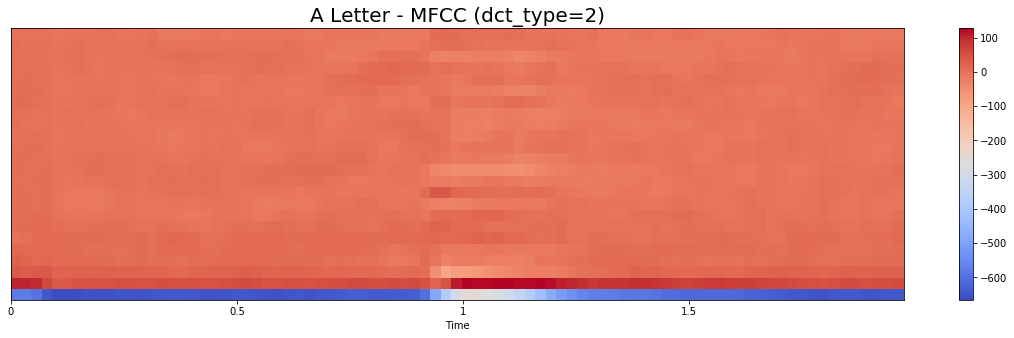

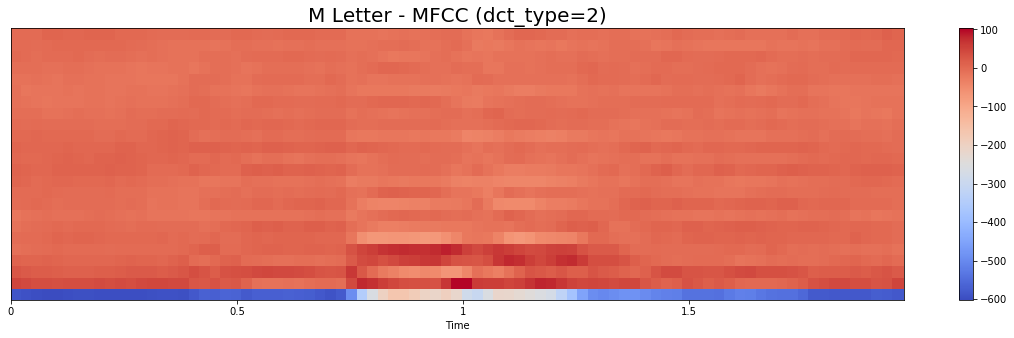

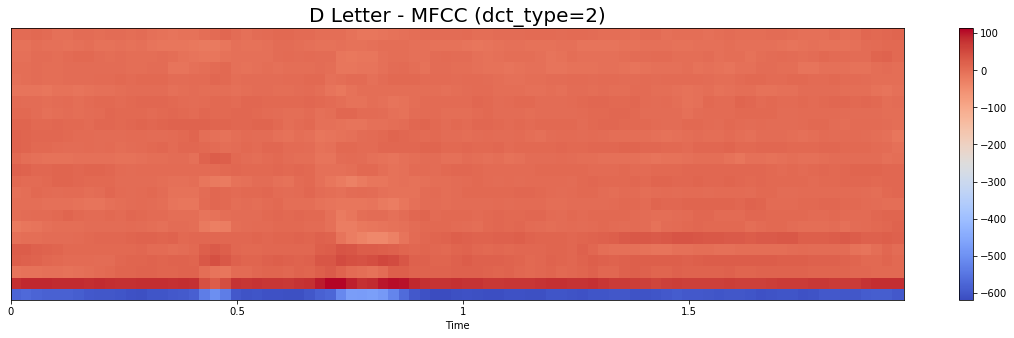

In [248]:
import librosa.display

def plot_mfcc(letter_sig, letter):
    m_slaney = librosa.feature.mfcc(y=letter_sig, sr=sr, n_mfcc=24, dct_type=2)
    plt.figure(figsize=(20, 5))
    librosa.display.specshow(m_slaney, x_axis='time')
    plt.title(f'{letter.upper()} Letter - MFCC (dct_type=2)', fontdict={'fontsize': 20})
    plt.colorbar()
    plt.savefig(f"mfcc_{letter}.png")
    plt.show()

def plt_chroma(letter_sig, letter):
    chr = librosa.feature.chroma_cqt(y=letter_sig, sr=sr, n_chroma=24)
    plt.figure(figsize=(20, 5))
    librosa.display.specshow(chr, y_axis='chroma')
    plt.title(f'Letter {letter.upper()} - CHROMA', fontdict={'fontsize': 20})
    plt.colorbar()
    plt.tight_layout()

    plt.savefig(f'chr_{letter}.png')
    plt.show()
    
def plot_mel_spec(letter_sig, letter):
    S = librosa.feature.melspectrogram(y=letter_sig, sr=sr, n_mels=128,fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(20, 5))
    librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{letter.upper()} Letter - Mel-frequency spectrogram',  fontdict={'fontsize': 20})
    plt.tight_layout()

    plt.savefig(f'mel_{letter}.png')
    plt.show()

    
for i in range(len(samples_df)):
    letter = samples_df.iloc[i,problem.shape[1]-1]
    letter_sig = samples_df.iloc[i,:problem.shape[1]-1].to_numpy(copy=True).astype(np.floating)
    plot_mfcc(letter_sig, letter)




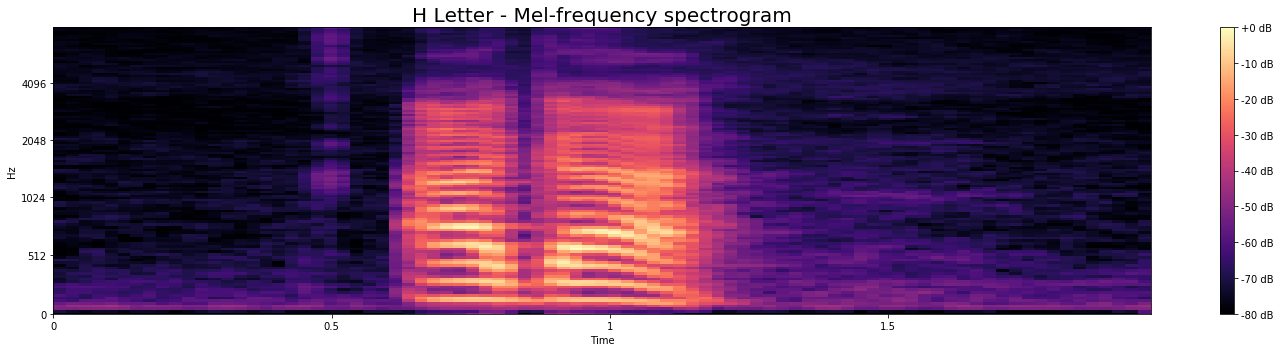

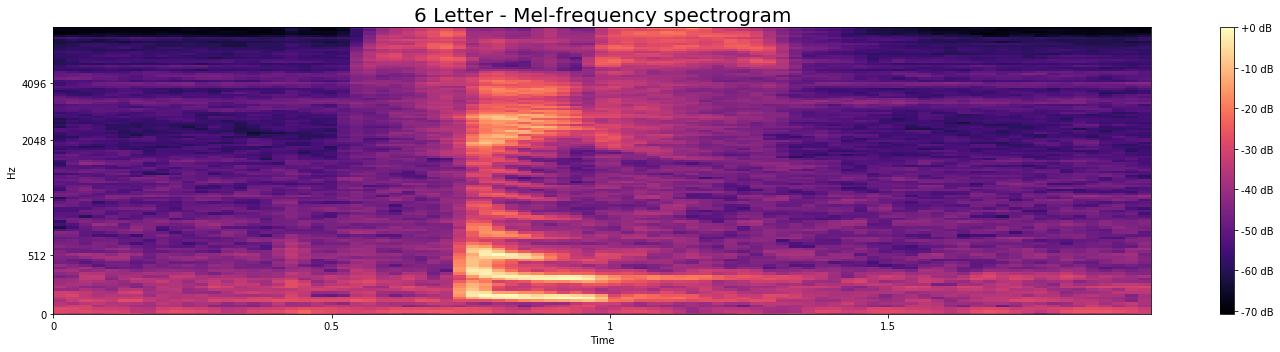

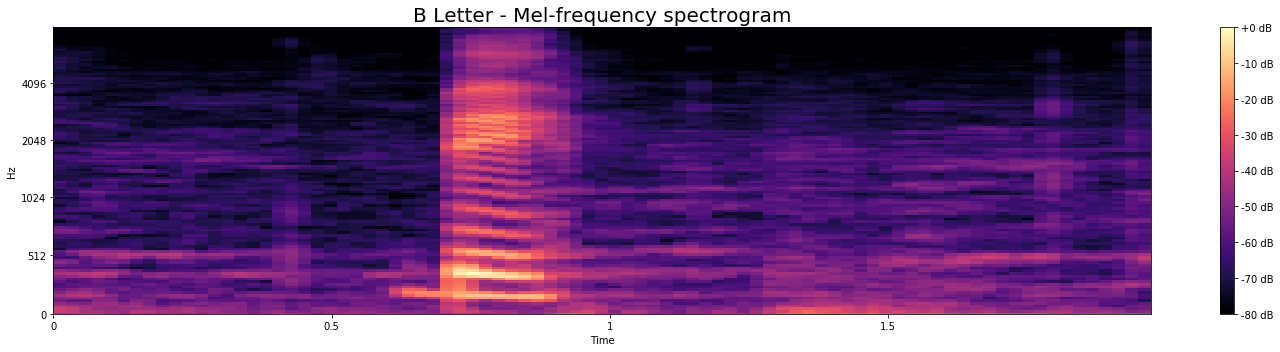

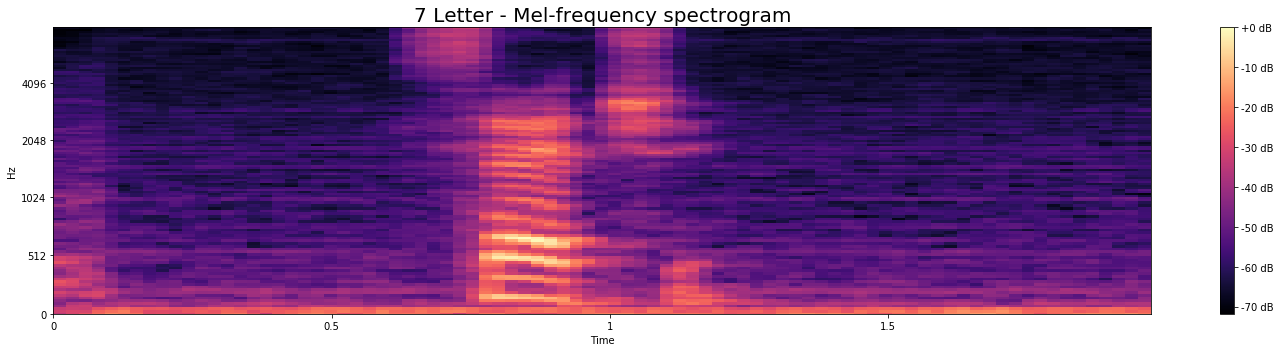

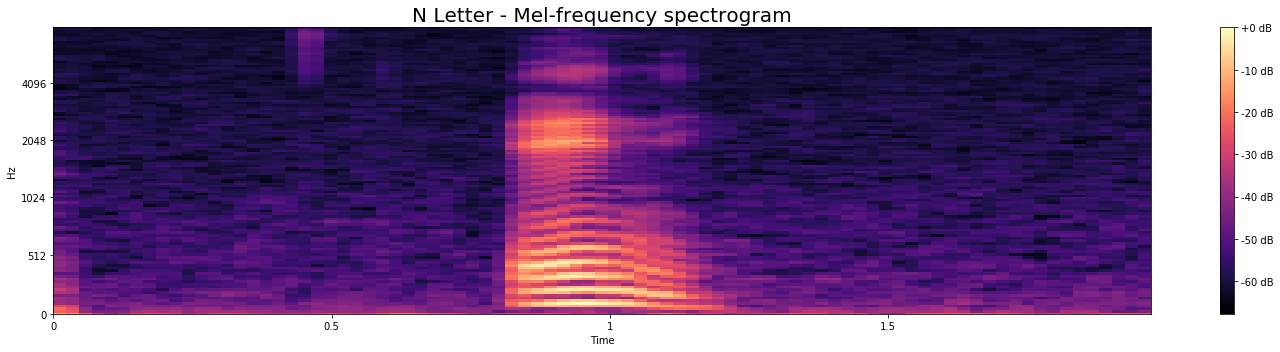

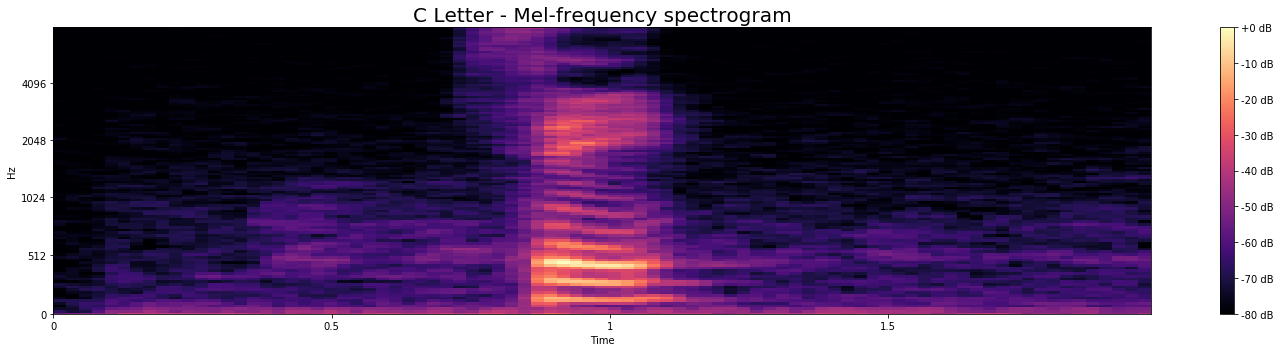

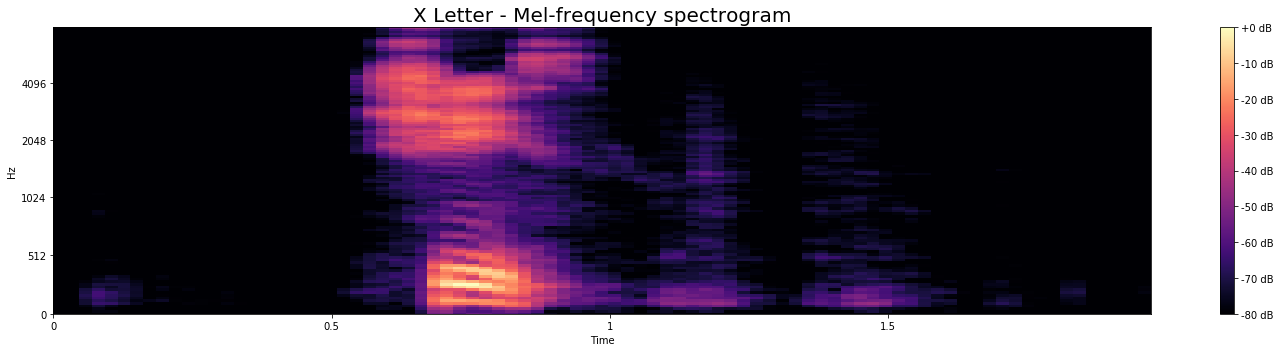

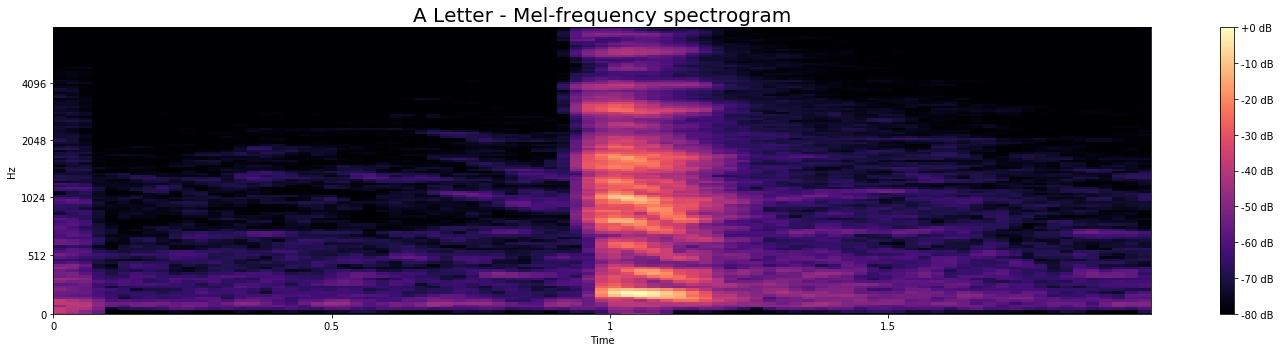

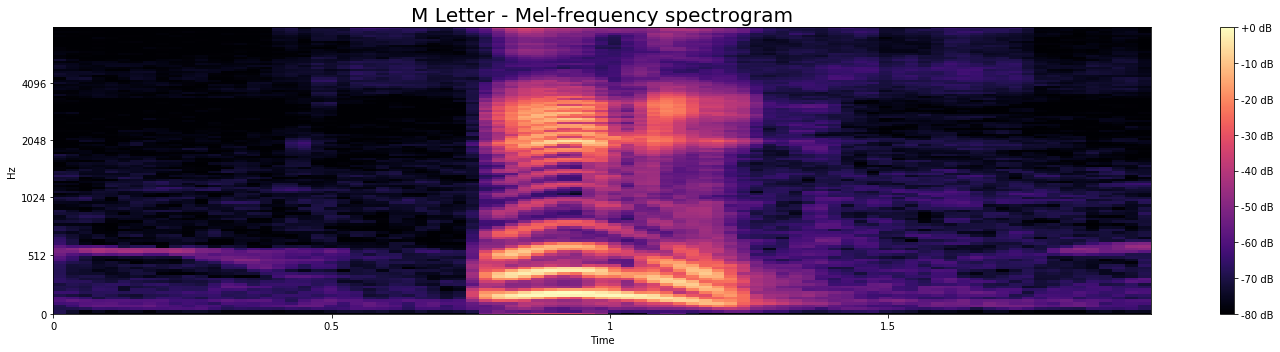

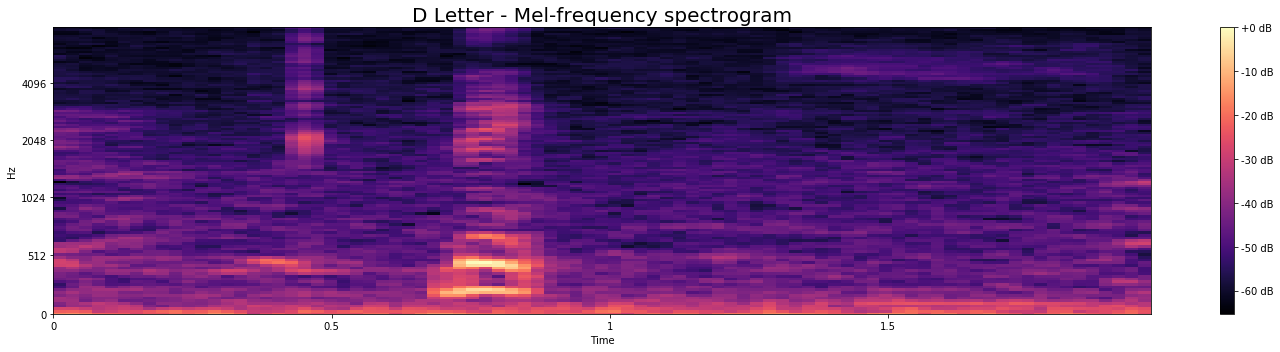

In [249]:
for i in range(len(samples_df)):
    letter = samples_df.iloc[i,problem.shape[1]-1]
    letter_sig = samples_df.iloc[i,:problem.shape[1]-1].to_numpy(copy=True).astype(np.floating)
    plot_mel_spec(letter_sig, letter)


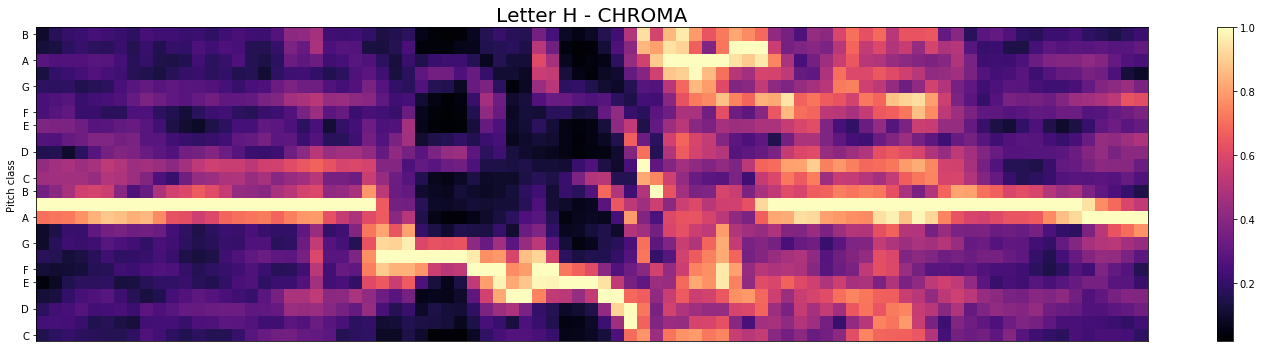

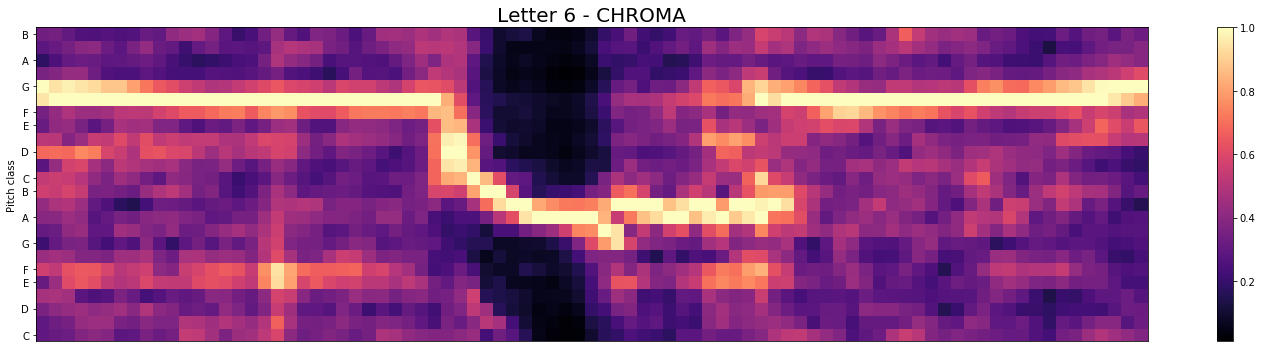

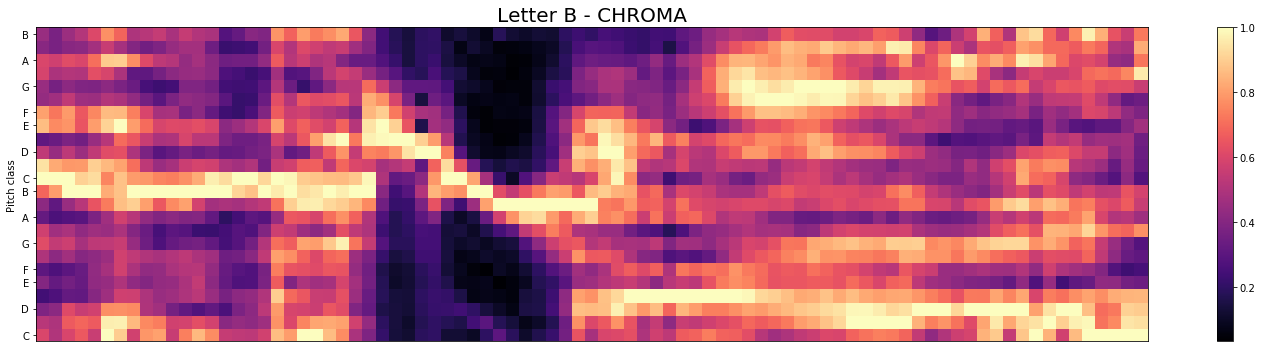

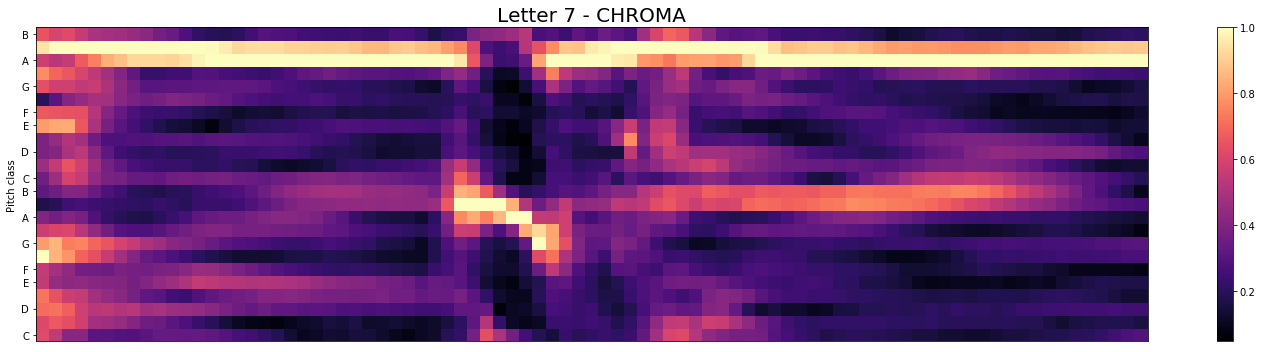

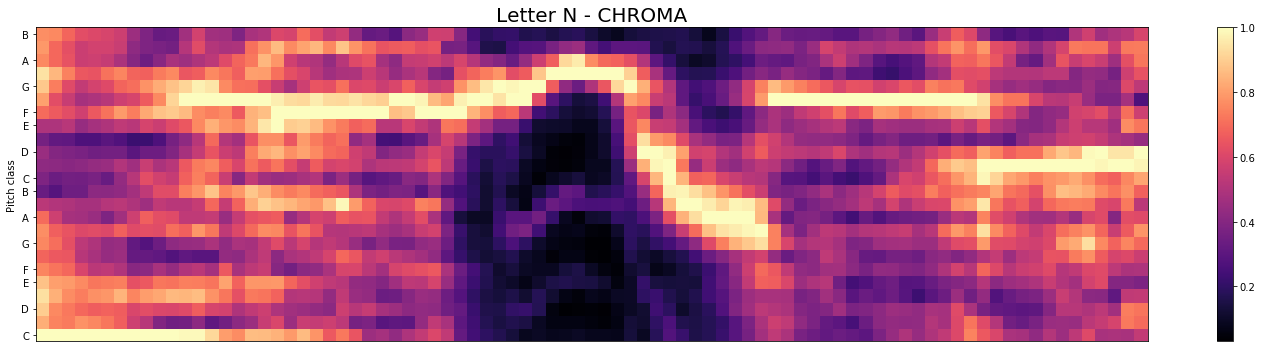

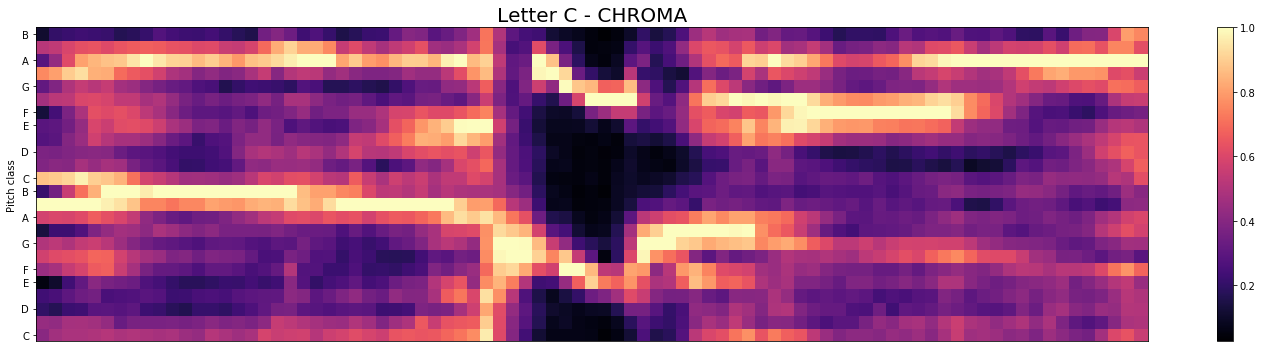

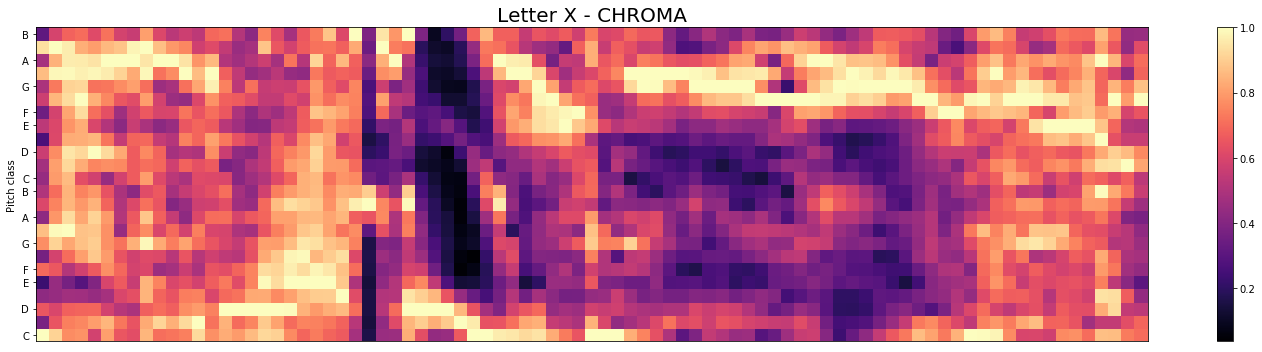

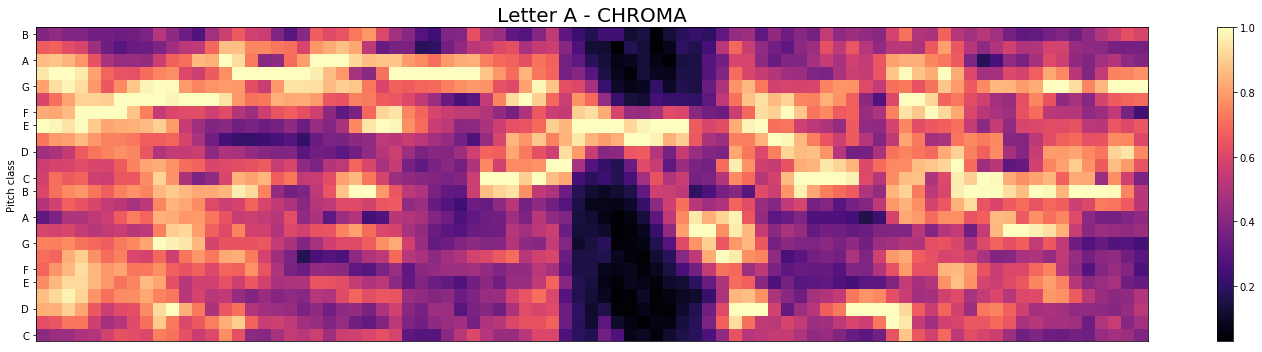

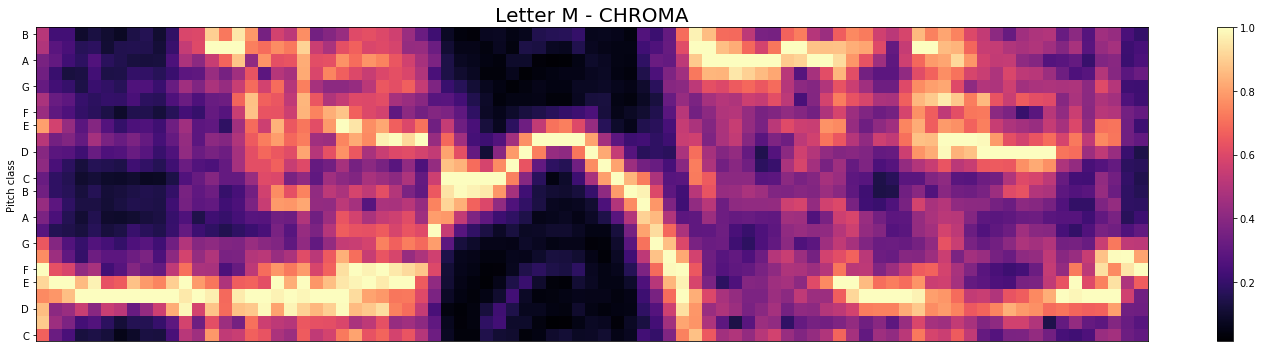

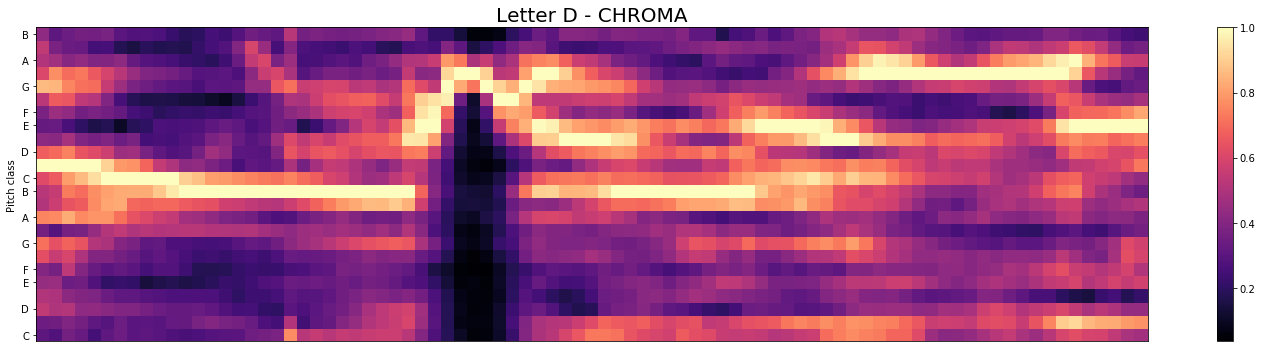

In [250]:

for i in range(len(samples_df)):
    letter = samples_df.iloc[i,problem.shape[1]-1]
    letter_sig = samples_df.iloc[i,:problem.shape[1]-1].to_numpy(copy=True).astype(np.floating)
    plt_chroma(letter_sig, letter)

